[View in Colaboratory](https://colab.research.google.com/github/Muosvr/fastai/blob/master/lesson1_rxt50.ipynb)

## Dogs v Cats super-charged!

In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
!pip3 install torch torchvision

In [0]:
!pip install fastai

In [0]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from PIL import Image

PATH = "dogscats_small/"
sz=299
arch=resnext50
bs=28

In [9]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving dogscats_small.zip to dogscats_small.zip
User uploaded file "dogscats_small.zip" with length 3728981 bytes


In [10]:
ls

datalab/  dogscats_small.zip


In [0]:
!unzip dogscats_small.zip

In [12]:
!ls {PATH}

test  train  valid


In [23]:
!wget http://files.fast.ai/models/weights.tgz

--2018-07-13 18:31:39--  http://files.fast.ai/models/weights.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1195411318 (1.1G) [text/plain]
Saving to: ‘weights.tgz’

weights.tgz         100%[===================>]   1.11G   102MB/s    in 11s     

2018-07-13 18:31:51 (101 MB/s) - ‘weights.tgz’ saved [1195411318/1195411318]



In [25]:
!tar -xvzf weights.tgz

weights/
weights/wrn_50_2f.pth
weights/resnext_101_32x4d.pth
weights/resnext_101_64x4d.pth
weights/inceptionresnetv2-d579a627.pth
weights/inceptionv4-97ef9c30.pth
weights/resnext_50_32x4d.pth


In [0]:
mv weights.tgz /usr/local/lib/python3.6/dist-packages/fastai/

In [32]:
!cd /usr/local/lib/python3.6/dist-packages/fastai/; tar -xvzf weights.tgz

weights/
weights/wrn_50_2f.pth
weights/resnext_101_32x4d.pth
weights/resnext_101_64x4d.pth
weights/inceptionresnetv2-d579a627.pth
weights/inceptionv4-97ef9c30.pth
weights/resnext_50_32x4d.pth


In [34]:
!ls /usr/local/lib/python3.6/dist-packages/fastai/weights

inceptionresnetv2-d579a627.pth	resnext_101_32x4d.pth  resnext_50_32x4d.pth
inceptionv4-97ef9c30.pth	resnext_101_64x4d.pth  wrn_50_2f.pth


In [35]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


In [36]:
learn.fit(1e-2, 1)
learn.precompute=False

epoch      trn_loss   val_loss   accuracy   
    0      0.489892   0.452603   0.888889  



In [37]:
learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.385915   0.409355   0.916667  
    1      0.26561    0.28521    0.958333  



[array([0.28521]), 0.9583333233992258]

In [0]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [39]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.23333    0.207046   0.972222  
    1      0.2266     0.138118   0.986111  
    2      0.174868   0.08591    0.986111  



[array([0.08591]), 0.9861111111111112]

In [0]:
learn.save('224_all_50')

In [0]:
learn.load('224_all_50')

In [74]:
ls dogscats_small/models

224_all_50.h5


In [47]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

accuracy_np(probs,y)

0.9861111111111112

## Analyzing results

In [0]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[36  0]
 [ 1 35]]


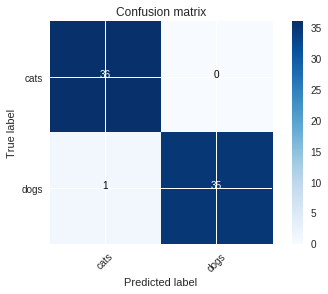

In [49]:
plot_confusion_matrix(cm, data.classes)

In [0]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

# def load_img_id(ds, idx, path = PATH): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))
def load_img_id(ds, idx, path = PATH): return np.array(Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

In [60]:
PATH

'dogscats_small/'

In [68]:
import PIL
from PIL import Image
Image

<module 'PIL.Image' from '/usr/local/lib/python3.6/dist-packages/PIL/Image.py'>

In [57]:
most_by_correct(0, False)

array([64])

In [0]:
??load_img_id

In [0]:
# workaround 
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

Most incorrect cats


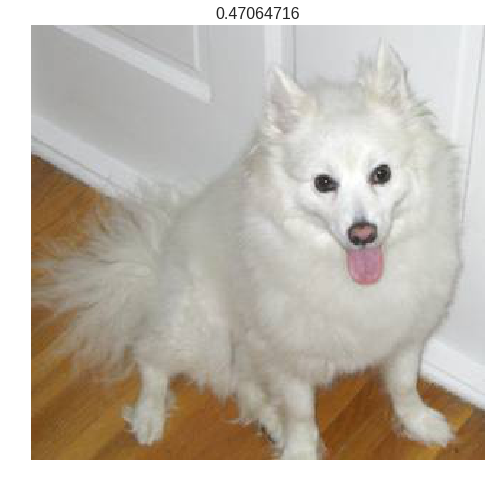

In [72]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


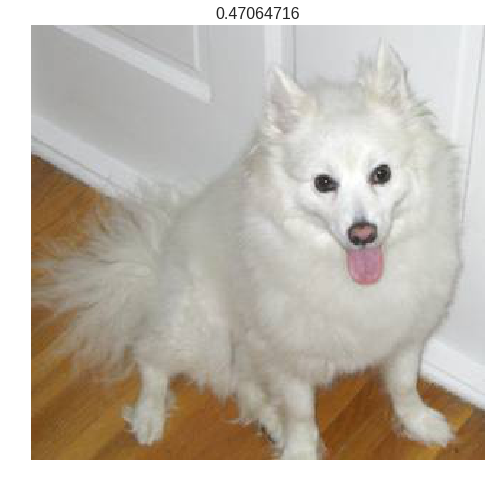

In [73]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Correctly classified


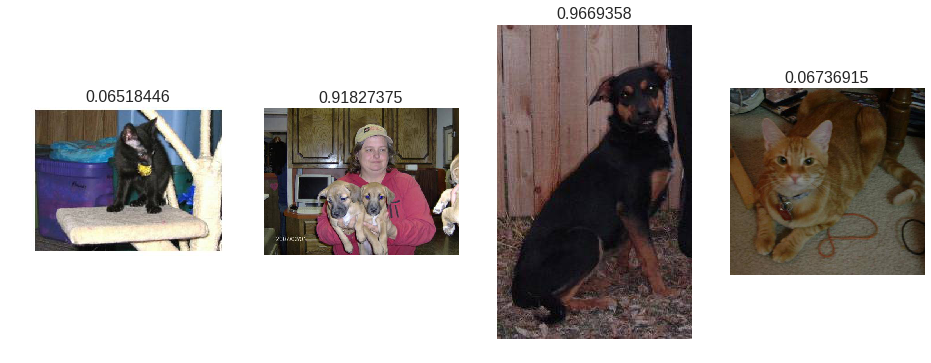

In [79]:
plot_val_with_title(rand_by_correct(True),"Correctly classified")

In [81]:
!ls dogscats_small/test

10.jpg	14.jpg	18.jpg	21.jpg	25.jpg	29.jpg	32.jpg	36.jpg	6.jpg
11.jpg	15.jpg	19.jpg	22.jpg	26.jpg	2.jpg	33.jpg	3.jpg	7.jpg
12.jpg	16.jpg	1.jpg	23.jpg	27.jpg	30.jpg	34.jpg	4.jpg	8.jpg
13.jpg	17.jpg	20.jpg	24.jpg	28.jpg	31.jpg	35.jpg	5.jpg	9.jpg


In [0]:
trn_tfms, val_tfrms = tfms_from_model(arch, sz)

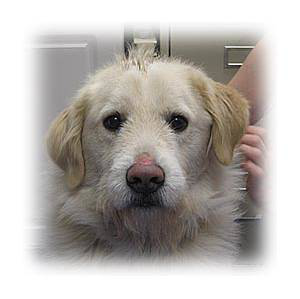

In [89]:
Image.open(f'{PATH}test/3.jpg')

In [90]:
im = val_tfrms(Image.open(f'{PATH}test/3.jpg'))

AttributeError: ignored